# Базовий фреймворк для задач задоволення обмежень

Базова модель задачі задоволення обмежень:

In [400]:
from typing import Generic, TypeVar, Dict, List, Optional
from abc import ABC, abstractmethod

V = TypeVar('V') # variable type
D = TypeVar('D') # domain type

# Base class for all constraints
class Constraint(Generic[V, D], ABC):
    def __init__(self, variables: List[V]) -> None:
        self.variables = variables

    @abstractmethod
    def satisfied(self, assignment: Dict[V, D]) -> bool:
        ...

# A constraint satisfaction problem consists of variables of type V
# that have ranges of values known as domains of type D and constraints
# that determine whether a particular variable's domain selection is valid
class CSPBase(Generic[V, D]):
    def __init__(self, variables: List[V], domains: Dict[V, List[D]]) -> None:
        self.variables: List[V] = variables # variables to be constrained
        self.domains: Dict[V, List[D]] = domains # domain of each variable
        self.node_count = 0
        self.constraints: Dict[V, List[Constraint[V, D]]] = {}
        for variable in self.variables:
            self.constraints[variable] = []
            if variable not in self.domains:
                raise LookupError("Every variable should have a domain assigned to it.")

    def add_constraint(self, constraint: Constraint[V, D]) -> None:
        for variable in constraint.variables:
            if variable not in self.variables:
                raise LookupError("Variable in constraint not in CSP")
            else:
                self.constraints[variable].append(constraint)

    # Check if the value assignment is consistent by checking all constraints
    # for the given variable against it
    def consistent(self, variable: V, assignment: Dict[V, D]) -> bool:
        for constraint in self.constraints[variable]:
            if not constraint.satisfied(assignment):
                return False
        return True



In [401]:
class CSP(CSPBase[V, D]):
    def __init__(self, variables: List[V], domains: Dict[V, List[D]]) -> None:
        super().__init__(variables, domains)

    def backtracking_search(self, assignment: Dict[V, D] = {}) -> Optional[Dict[V, D]]:
        if len(assignment) != len(self.variables):
            self.node_count += len(self.domains[self.variables[len(assignment)]])
        
        if len(assignment) == len(self.variables):
            return assignment

        unassigned: List[V] = [v for v in self.variables if v not in assignment]
        first: V = unassigned[0]
        for value in self.domains[first]:
            local_assignment = assignment.copy()
            local_assignment[first] = value
            if self.consistent(first, local_assignment):
                result: Optional[Dict[V, D]] = self.backtracking_search(local_assignment)
                if result is not None:
                    return result
        return None


In [402]:
class CSPWithHeuristics(CSPBase[V, D]):
    def __init__(self, variables: List[V], domains: Dict[V, List[D]]):
        super().__init__(variables, domains)

    def mcv(self, unassigned: List[V]) -> V:
        return min(unassigned, key=lambda var: len(self.domains[var]))

    def lcv(self, variable: V) -> List[D]:
        if len(self.domains[variable]) == 1:
            return self.domains[variable]
        else:
            count = {}
            for value in self.domains[variable]:
                self.assignment[variable] = value
                count[value] = sum(self.consistent(var, self.assignment) for var in self.variables if var not in self.assignment)
                del self.assignment[variable]
        return sorted(self.domains[variable], key=lambda x: -count[x])

            
    def backtracking_search(self, assignment: Dict[V, D] = {}) -> Optional[Dict[V, D]]:
        self.assignment = assignment
        
        if len(assignment) != len(self.variables):
            self.node_count += len(self.domains[self.mcv([v for v in self.variables if v not in assignment])])
        
        if len(assignment) == len(self.variables):
            return assignment

        unassigned: List[V] = [v for v in self.variables if v not in assignment]
        variable: V = self.mcv(unassigned)
        for value in self.lcv(variable):
            local_assignment = assignment.copy()
            local_assignment[variable] = value
            if self.consistent(variable, local_assignment):
                result: Optional[Dict[V, D]] = self.backtracking_search(local_assignment)
                if result is not None:
                    return result
        return None

In [403]:
class CSPBeamSearch(CSPBase[V, D]):
    def __init__(self, variables: List[V], domains: Dict[V, List[D]], beam_width: int) -> None:
        super().__init__(variables, domains)
        self.beam_width = beam_width

    def heuristic(self, assignment: Dict[V, D]) -> int:
        num_conflicts = 0
        for variable in assignment:
            for constraint in self.constraints[variable]:
                if not constraint.satisfied(assignment):
                    num_conflicts += 1
        return num_conflicts

    def backtracking_search(self, assignment: Dict[V, D] = {}) -> Optional[Dict[V, D]]:
        assignments = [assignment]

        while assignments:
            new_assignments = []
            for assignment in assignments:
                if len(assignment) == len(self.variables):
                    return assignment
                
                unassigned = [v for v in self.variables if v not in assignment]
                variable = unassigned[0]
                
                # count every node when it's generated
                self.node_count += len(self.domains[variable])
                
                for value in self.domains[variable]:
                    new_assignment = assignment.copy()
                    new_assignment[variable] = value
                    if self.consistent(variable, new_assignment):
                        new_assignments.append(new_assignment)

            new_assignments.sort(key=self.heuristic)
            assignments = new_assignments[:self.beam_width]

        return None



# Задача розфарбовування карти

Реалізація обмеження задачі:

In [404]:
class MapColoringConstraint(Constraint[str, str]):
    def __init__(self, place1: str, place2: str) -> None:
        super().__init__([place1, place2])
        self.place1: str = place1
        self.place2: str = place2

    def satisfied(self, assignment: Dict[str, str]) -> bool:
        # If either place is not in the assignment then it is not
        # yet possible for their solution to be conflicting
        if self.place1 not in assignment or self.place2 not in assignment:
            return True
        # check the color assigned to place1 is not the same as the
        # color assigned to place2
        return assignment[self.place1] != assignment[self.place2]

#### Рішення для Франції:

In [405]:
import networkx as nx
import matplotlib.pyplot as plt

variables: List[str] = [
    'Hauts-de-France', 'Normandie', 'Ile-de-France', 'Grand-Est', 'Bretagne', 
    'Pays-de-la-Loire', 'Centre-Val de Loire', 'Bourgone-Franche-comte', 
    'Nouvelle-Aquitaine', 'Auvergne-Rhone-Alpes', 'Occitanle', 
    'Provence-Alpes-Cote d\'Azur', 'Corsica'
]

domains: Dict[str, List[str]] = {}
for variable in variables:
    domains[variable] = ["red", "green", "orange", "pink", "purple", "blue"]

edges = [
    ('Hauts-de-France', 'Normandie'),
    ('Hauts-de-France', 'Ile-de-France'),
    ('Hauts-de-France', 'Grand-Est'),
    ('Normandie', 'Ile-de-France'),
    ('Normandie', 'Bretagne'),
    ('Normandie', 'Pays-de-la-Loire'),
    ('Normandie', 'Centre-Val de Loire'),
    ('Ile-de-France', 'Grand-Est'),
    ('Ile-de-France', 'Centre-Val de Loire'),
    ('Ile-de-France', 'Bourgone-Franche-comte'),
    ('Grand-Est', 'Bourgone-Franche-comte'),
    ('Pays-de-la-Loire', 'Bretagne'),
    ('Pays-de-la-Loire', 'Nouvelle-Aquitaine'),
    ('Pays-de-la-Loire', 'Centre-Val de Loire'),
    ('Centre-Val de Loire', 'Bourgone-Franche-comte'),
    ('Centre-Val de Loire', 'Auvergne-Rhone-Alpes'),
    ('Centre-Val de Loire', 'Nouvelle-Aquitaine'),
    ('Bourgone-Franche-comte', 'Auvergne-Rhone-Alpes'),
    ('Nouvelle-Aquitaine', 'Auvergne-Rhone-Alpes'),
    ('Nouvelle-Aquitaine', 'Occitanle'),
    ('Auvergne-Rhone-Alpes', 'Occitanle'),
    ('Auvergne-Rhone-Alpes', 'Provence-Alpes-Cote d\'Azur'),
    ('Occitanle', 'Provence-Alpes-Cote d\'Azur'),
]



In [406]:
csp_beam: CSPBeamSearch[str, str] = CSPBeamSearch(variables, domains, beam_width=3)
csp_back: CSP[str, str] = CSP(variables, domains)
csp_heur: CSPWithHeuristics[str, str] = CSPWithHeuristics(variables, domains)

for edge in edges:
    csp_beam.add_constraint(MapColoringConstraint(*edge))
    csp_back.add_constraint(MapColoringConstraint(*edge))
    csp_heur.add_constraint(MapColoringConstraint(*edge))

### Run the algorithms and record the time taken

In [407]:
import time
import tracemalloc

# Beam Search
tracemalloc.start()
start_time = time.time()
solution_beam = csp_beam.backtracking_search()
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Beam Search took {end_time - start_time} seconds.")
print(f"Current memory usage: {current / 10**6} MiB")
print(f"Peak memory usage: {peak / 10**6} MiB")
print(f"Number of nodes viewed: {csp_beam.node_count} \n")

# Backtracking
tracemalloc.start()
start_time = time.time()
solution_back = csp_back.backtracking_search()
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Backtracking took {end_time - start_time} seconds.")
print(f"Current memory usage: {current / 10**6} MiB")
print(f"Peak memory usage: {peak / 10**6} MiB")
print(f"Number of nodes viewed: {csp_back.node_count} \n") 

# Backtracking with MCV and LCV heuristics
tracemalloc.start()
start_time = time.time()
solution_heur = csp_heur.backtracking_search()
end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"Backtracking with MCV and LCV heuristics took {end_time - start_time} seconds.")
print(f"Current memory usage: {current / 10**6} MiB")
print(f"Peak memory usage: {peak / 10**6} MiB")
print(f"Number of nodes viewed: {csp_heur.node_count} \n") 

if solution_beam is None and solution_back is None and solution_heur is None:
    print("No algorithm found a solution.")
elif solution_beam is None:
    print("Only Backtracking and Backtracking + MCV + LCV found a solution.")
elif solution_back is None:
    print("Only Beam Search and Backtracking + MCV + LCV found a solution.")
elif solution_heur is None:
    print("Only Beam Search and Backtracking found a solution.")
elif solution_beam == solution_back and solution_back == solution_heur:
    print("All algorithms found the same solution.")
else:
    print("The algorithms found different solutions.")


Beam Search took 0.002990245819091797 seconds.
Current memory usage: 0.010902 MiB
Peak memory usage: 0.02257 MiB
Number of nodes viewed: 222 

Backtracking took 0.0009963512420654297 seconds.
Current memory usage: 0.00852 MiB
Peak memory usage: 0.019652 MiB
Number of nodes viewed: 78 

Backtracking with MCV and LCV heuristics took 0.001994609832763672 seconds.
Current memory usage: 0.010672 MiB
Peak memory usage: 0.021456 MiB
Number of nodes viewed: 78 

All algorithms found the same solution.


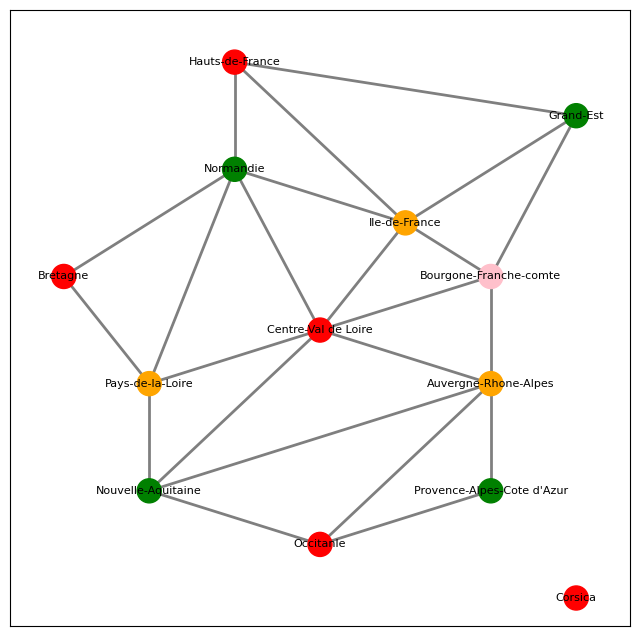

In [408]:
if solution_beam is not None and solution_back is not None:
    G = nx.Graph()
    for node, color in solution_beam.items():
        G.add_node(node, color=color)

    G.add_edges_from(edges)

    pos = nx.spring_layout(G)

    pos = {
        'Hauts-de-France': [0.3, 1.2],
        'Normandie': [0.3, 1],
        'Ile-de-France': [0.5, 0.9],
        'Grand-Est': [0.7, 1.1],
        'Bretagne': [0.1, 0.8],
        'Pays-de-la-Loire': [0.2, 0.6],
        'Centre-Val de Loire': [0.4, 0.7],
        'Bourgone-Franche-comte': [0.6, 0.8],
        'Nouvelle-Aquitaine': [0.2, 0.4],
        'Auvergne-Rhone-Alpes': [0.6, 0.6],
        'Occitanle': [0.4, 0.3],
        'Provence-Alpes-Cote d\'Azur': [0.6, 0.4], 
        'Corsica': [0.7, 0.2]
    }

    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(G, pos, node_color=[solution_beam[n] for n in G.nodes])
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.show()